In [13]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import glob

from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['text.usetex'] = True
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from matplotlib.gridspec import GridSpec

from scipy import interpolate
from scipy.special import expit
from matplotlib import cm

In [14]:
# Setze Helvetica als Standardschrift
plt.rcParams['font.family'] = 'Helvetica'

# Setze den Hintergrund von Figure und Axes auf #121212
plt.rcParams['figure.facecolor'] = '#121212'  # Hintergrund der gesamten Figur
plt.rcParams['axes.facecolor'] = '#121212'    # Hintergrund der Plot-Achsen

# Setze Schriftfarbe für Achsenlabels, Titel und Ticklabels auf #DDDDDD
plt.rcParams['text.color'] = '#DDDDDD'  
plt.rcParams['axes.labelcolor'] = '#DDDDDD'  
plt.rcParams['xtick.color'] = '#DDDDDD'  
plt.rcParams['ytick.color'] = '#DDDDDD'  

# Setze die Farbe der Rahmenlinien um den Plot (optional etwas dunkler)
plt.rcParams['axes.edgecolor'] = '#DDDDDD'  

background = '#121212'
mywhite = '#DDDDDD'

#core colors:
hellblau = '#56B4E9'
gruen = '#3D9B74'
sanftgelb = '#F2C94C'
koralle = '#F26B38'
rosa = '#F48FB1'

#backup colors
bahamagelb = '#F9C200'
chartreusegruen = '#A9E400'
weichmagenta = '#FF4081'
bordeaux = '#6A0D3D'

In [15]:
file = h5py.File("tightbinding.h5",'r')
grid = file['grid']
PL = file['data']

In [16]:
background_color = "#121212"  # Dunkelgrauer Hintergrund
grid_color = "#888888"  # Weiches Grau für Gitter
cmap = "cividis"  # Alternative: 'viridis', 'inferno', 'cividis'

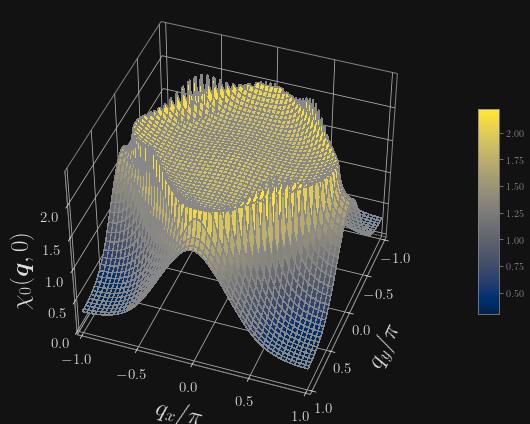

In [17]:
fig = plt.figure(figsize=(8,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111, projection="3d", facecolor=background_color)
X,Y = np.meshgrid(grid,grid)


plt.tight_layout()
surf = ax.plot_surface(X/np.pi,Y/np.pi, PL, cmap=cmap,antialiased=False,
                rcount=50,ccount=50,
               edgecolor=grid_color,linewidth=0.3)
'''
surf = ax.plot_surface(X/np.pi,Y/np.pi, PL, cmap=cmap,antialiased=False,
                rcount=500,ccount=500,
               edgecolor=grid_color,linewidth=0.00003)
'''

ax.azim = 20 
ax.dist = 10
ax.elev = 45
ax.zaxis.set_rotate_label(False)

ax.xaxis.pane.set_facecolor(background_color)
ax.yaxis.pane.set_facecolor(background_color)
ax.zaxis.pane.set_facecolor(background_color)

# Gitterlinien und Rahmenfarbe anpassen
ax.w_xaxis.line.set_color(grid_color)
ax.w_yaxis.line.set_color(grid_color)
ax.w_zaxis.line.set_color(grid_color)

ax.set_xlabel(r'$q_y/\pi$',fontsize=25,labelpad=15)
ax.set_ylabel(r'$q_x/\pi$',fontsize=25,labelpad=15)
ax.set_zlabel(r'$\chi_0(\boldsymbol{q},0)$',fontsize=25,rotation=90,labelpad=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
zlim=ax.get_zlim()
ax.set_zlim(0,zlim[1])

ax.tick_params(labelsize=15)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])

# Farbleiste anpassen
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.outline.set_edgecolor(grid_color)  # Rahmenfarbe der Farbskala
cbar.ax.yaxis.set_tick_params(color=grid_color)  # Tick-Farbe anpassen
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color=grid_color)  # Tick-Label-Farbe

fig.patch.set_facecolor(background_color)

#plt.savefig('staticSusceptibilityThesis.png',dpi=300,bbox_inches="tight")

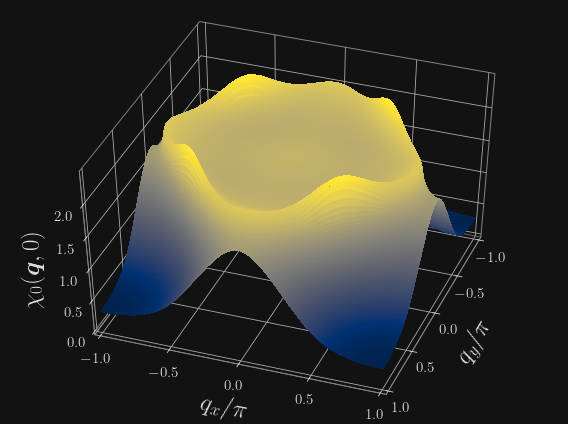

In [18]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(grid,grid)

plt.tight_layout()
#ax.plot_surface(X/np.pi,Y/np.pi, PL, cmap=cmap,antialiased=False,rcount=50,ccount=50,
 #               edgecolor=grid_color,linewidth=0.3)
ax.plot_surface(X/np.pi,Y/np.pi, PL, cmap=cmap,antialiased=False,
                rcount=500,ccount=500,
               edgecolor=grid_color,linewidth=0.00000001)

ax.azim = 20 
ax.dist = 10
ax.elev = 45
ax.zaxis.set_rotate_label(False)

ax.set_xlabel(r'$q_y/\pi$',fontsize=25,labelpad=15)
ax.set_ylabel(r'$q_x/\pi$',fontsize=25,labelpad=15)
ax.set_zlabel(r'$\chi_0(\boldsymbol{q},0)$',fontsize=25,rotation=90,labelpad=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
zlim=ax.get_zlim()
ax.set_zlim(0,zlim[1])

ax.tick_params(labelsize=15)
ax.set_xticks([-1,-0.5,0,0.5,1],minor=False)
ax.set_yticks([-1,-0.5,0,0.5,1],minor=False)
ax.minorticks_off()

ax.xaxis.pane.set_facecolor(background_color)
ax.yaxis.pane.set_facecolor(background_color)
ax.zaxis.pane.set_facecolor(background_color)

ax.w_xaxis.line.set_color(grid_color)
ax.w_yaxis.line.set_color(grid_color)
ax.w_zaxis.line.set_color(grid_color)

plt.savefig('staticSusceptibility_dark.png',dpi=600,bbox_inches="tight",transparent=True)